# Проверка результатов А/Б теста

Эксперимент проходил с 2023-10-25 по 2023-10-31 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR.

Задачи:
1. Выбрать метод анализа и сравнить CTR в двух группах

2. Сравните данные несколькими тестами. Почему тесты сработали именно так? 

3. Описать потенциальную ситуацию, когда такое изменение могло произойти.

4. Дать рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.


In [1]:
#Импортируем библиотеки
import pandas as pd
import pandahouse as ph
import seaborn as sns
from scipy import stats
import numpy as np

#подключаемся к нужной схеме данных
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator',
'user':'student',
'password':'dpo_python_2020'
}

#Задаем размер графика
sns.set(rc={'figure.figsize':(15,10)})

In [2]:
#Выгружаем нужные данные
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20231113.feed_actions 
WHERE toDate(time) between '2023-10-25' and '2023-10-31'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

In [3]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


Данные распределились +/- равномерно, но выборки не одинаковы.

In [4]:
df.head(20)

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,18392,7,32,0.218750
4,1,26295,39,141,0.276596
5,2,131473,9,108,0.083333
6,2,23985,7,87,0.080460
7,2,24523,11,101,0.108911
8,2,32420,13,44,0.295455
9,2,24239,40,90,0.444444


Данные выглядят корректно, посмотрим их распределение, прежде всего нас интересует метрика по которой мы будем принимать решение - ctr.

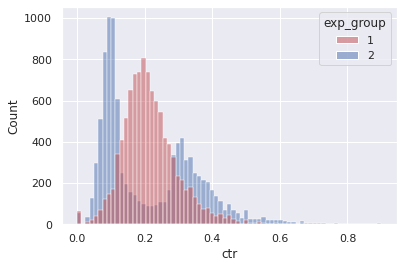

In [5]:
sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False);

CTR распределился нормально только в группе №1, группа №2 распределилась бимодально. Сразу можно сказать, что т-тесту будет непросто и наврядли он сработает корректно. Проверим как сработают различные тесты на полученных данных.

# Т-тест

Н0 - среднее значение CTR в группах №1 и №2 равны

Н1 - среднее значение CTR в группах №1 и №2 отличается

In [6]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr, 
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

Как видим, в данном случае отвергнуть нулевую гипотезу не получится, по результатам теста средние равны.

# Тест Манна-Уитни

In [ ]:
Проведем тест Манна-Уитни.

In [7]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

Значение p-value даже еще больше, в данной ситуации он показывает себя еще хуже. Почему хуже? Обратимся к Пуассоновскому бутстрепу.

# Пуассоновский бутстреп

Воспроизведем функцию из конспекта

In [8]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2






Формируем псевдо выборки

In [9]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)



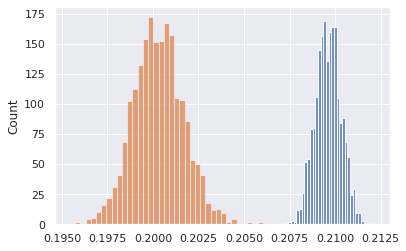

In [23]:
sns.histplot(ctr1)
sns.histplot(ctr2);

In [22]:
stats.ttest_ind(ctr1,
                ctr2, 
                equal_var=False)

Ttest_indResult(statistic=267.9227309285673, pvalue=0.0)

Как и в лекции мы видим, что разница в глобальном CTR по группам сильно разнится, и проведенный т-тест на них показывает ноль, средние значения точно не равны.

<Axes: ylabel='Count'>

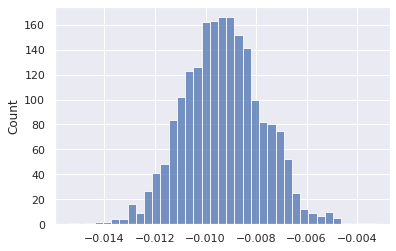

In [20]:
sns.histplot(ctr2-ctr1);

Хоть мы и увидели, что в конечном счете не все методы тестирования могут обнаружить разницу между выборками, надо принять окончательное решение. Так как мы вычитаем контрольную группу из тестовой и значения отрицательные, значит показатели CTR в тестовой группе хуже.

### Итоговая реккомендация
Раскатывать итоговый алгоритм на все группы не стоит.